# Solving Everyday Problems: What do I watch next?

In this project, I aim to solve the age-old problem of what to watch next. People know what movies they like, or even love, but how many duds does one have to go through to find the next great movie they will enjoy? I aim to significantly reduce the amount of time a person would need both to decide on a movie to watch as well as find a movie they will enjoy. I hope to build a program that takes in information about the current user that is looking to see a movie in the form of three movies and plots that the user already knows they enjoy and recommends the next movie that they should not only watch but should enjoy based on their preferences. With people wanting to move quicker and integrate more automation into their lives, this could be a huge success. Additionally, if the theory behind the program works, this could be extrapolated to other sectors such as recommending restaurants, nightlife, books, or anything else!

The data in this project is scraped from two sources. Our list of popular titles in a genre comes from Ranker, a site that allows the public to vote on which movies they feel are the best of all time in a particular category. Our movie plot, rating, and year data comes from IMDB via the OMDB Api, a site that is a large database of all movie data.

In [17]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
import random
import os
import scrapy
from scrapy.crawler import CrawlerProcess
%matplotlib inline
from sklearn.model_selection import cross_val_score
import seaborn as sns

#Importing Title, Year, Rating, Plot data scraped from IMDB
comedy = pd.read_json('CMovies.json', orient='records')
horror = pd.read_json('HorMovies.json', orient='records')
action = pd.read_json('ActMovies.json', orient='records')
crime = pd.read_json('CriMovies.json', orient='records')
drama = pd.read_json('DraMovies.json', orient='records')
family = pd.read_json('FamMovies.json', orient='records')
history = pd.read_json('HisMovies.json', orient='records')
romance = pd.read_json('RomMovies.json', orient='records')
scifi = pd.read_json('SFMovies.json', orient='records')
thriller = pd.read_json('ThrMovies.json', orient='records')
western = pd.read_json('WesMovies.json', orient='records')

# Importing movie titles data scraped from Ranker
comedy_title = pd.read_json('Comedy.json', orient='records')
horror_title = pd.read_json('Horror.json', orient='records')
action_title = pd.read_json('Action.json', orient='records')
crime_title = pd.read_json('Crime.json', orient='records')
drama_title = pd.read_json('Drama.json', orient='records')
family_title = pd.read_json('Family.json', orient='records')
history_title = pd.read_json('History.json', orient='records')
romance_title = pd.read_json('Romance.json', orient='records')
scifi_title = pd.read_json('SciFi.json', orient='records')
thriller_title = pd.read_json('Thriller.json', orient='records')
western_title = pd.read_json('Western.json', orient='records')

In [18]:
# Cleaning data to replace any characters we don't want to applies to every dataset in lst (list)
# Input for Clean data is a list of genre data
def clean_data(lst):
    for item in lst:
        # Clean up year information
        item.Year = item.Year.apply(lambda x: str(x).replace('–','') )
        item.Year = item.Year.apply(lambda x: int(x))
        
        #Get rid of N/A in Plot and rating
        item.Plot = item.Plot.apply(lambda x: str(x).replace('N/A', ''))
        
        #Setting N/A to 0 for rating as ratings are between 1-10
        item.Rating = item.Rating.apply(lambda x: str(x).replace('N/A', '0'))
        item.Rating = item.Rating.apply(lambda x: float(x))
        
    return lst

# Collecting all genre data into one list
genre_data = [comedy,horror,action,crime,drama,family,history,romance,scifi,thriller,western]

# Applying data cleaning fucntion to our list of genre data
genre_data = clean_data(genre_data)

## Data Exploration

We will use methods to analyze each set of plots to identify common digrams of each.

In [45]:
def top_digrams(genre):
    # Combine all plots into one string
    Genre_Plots = []
    for plot in genre.Plot:
        Genre_Plots.append(plot)
    Genre_Plots = ' '.join(Genre_Plots)

    # We want to use the standard english-language parser.
    parser = spacy.load('en')

    # Parsing genre plots
    genre_plots = parser(Genre_Plots)

    # Create list of all two-word phrases
    word = [word for word in genre_plots if((word.is_stop==False) and (word.is_punct==False) and (word.pos_=='NOUN' or word.pos_=='ADJ'))]
    genre_pair = []
    for i,item in enumerate(word):
        if i+1 < len(word):
            genre_pair.append(str(item)+' '+str(word[i+1]))

    pairs = set(genre_pair)

    # Creating a grid indicating whether words are within 4 places of the target word
    adjacency=pd.DataFrame(columns=pairs,index=pairs,data=0)


    # Iterating through each word in the text and indicating which of the unique words are its neighbors
    for i,word in enumerate(genre_pair):
        #Making sure to stop at the end of the string, even if there are less than four words left after the target.
        end=max(0,len(genre_pair)-(len(genre_pair)-(i+15)))
        # The potential neighbors.
        nextwords=genre_pair[i+1:end]
        # Filtering the neighbors to select only those in the word list
        neighbors=[nextwords[i] for i in range(len(nextwords))]
        adjacency.loc[word,neighbors]=adjacency.loc[word,neighbors]+1

    # Running TextRank
    nx_pairs = nx.from_numpy_matrix(adjacency.as_matrix())
    ranks=nx.pagerank(nx_pairs, alpha=.85, tol=.00000001)

    # Identifying the five most highly ranked keywords
    ranked = sorted(((ranks[i],s) for i,s in enumerate(pairs)),
                    reverse=True)
    
    # Get only the digrams and store them to be returned
    top_five = []
    for dia in ranked[:5]:
        top_five.append(dia[1])
    
    return top_five

In [50]:
top_word_dict = {
    'comedy': top_digrams(comedy),
    'horror': top_digrams(horror),
    'family': top_digrams(family),
    'action': top_digrams(action),
    'drama': top_digrams(drama),
    'romance': top_digrams(romance),
    'crime': top_digrams(crime),
    'western': top_digrams(western),
    'history': top_digrams(history),
    'thriller': top_digrams(thriller),
    'scifi': top_digrams(scifi)
}

In [52]:
display(pd.DataFrame(top_word_dict))

,action,comedy,crime,drama,family,history,horror,romance,scifi,thriller,western
0,year old,best friend,police force,year old,year old,year old,serial killer,high school,life form,tennis player,white man
1,drug dealers,high school,best friend,nursing home,young boy,old actor,year old,love life,human race,evil organization,cattle thieves
2,drug dealer,birthday party,family business,members 2nd,night watchman,relationship career,urban legend,year old,year old,Bond mission,young gun
3,aliens survivors,Their quest,maximum security,state police,true love,humorous meaningful,gas station,best friend,alien spacecraft,secret service,bounty hunters
4,rescue mission,love life,crime boss,non whites,epic journey,meaningful sequence,young boy,true love,sci fi,time machine,story town


In [12]:
# We will use plot, rating, and year for all of our classifiers

# Initializing vectorizer to use for fitting all of genre plot data
vectorizer = TfidfVectorizer(lowercase=False, # Do not convert all to lowercase before tokenizing
                          stop_words=None, # Do not remove any stopwords
                          ngram_range=(1, 1), # Looking at each word individually ngram = 1
                            analyzer=u'word'
                          max_df=.5, # Drop words that occur in more than half of the plots
                          min_df=1, # Use words that appear at least once (all words)
                                
                            )

# Fit and transform vectorizer for every genere's list of plots
# Get all words in the plot data and store terms
comPlot = vectorizer.fit_transform(comedy.Plot)
com_terms = vectorizer.get_feature_names()
horPlot = vectorizer.fit_transform(horror.Plot)
hor_terms = vectorizer.get_feature_names()
famPlot = vectorizer.fit_transform(family.Plot)
fam_terms = vectorizer.get_feature_names()
actPlot = vectorizer.fit_transform(action.Plot)
act_terms = vectorizer.get_feature_names()
criPlot = vectorizer.fit_transform(crime.Plot)
cri_terms = vectorizer.get_feature_names()
draPlot = vectorizer.fit_transform(drama.Plot)
dra_terms = vectorizer.get_feature_names()
hisPlot = vectorizer.fit_transform(history.Plot)
his_terms = vectorizer.get_feature_names()
romPlot = vectorizer.fit_transform(romance.Plot)
rom_terms = vectorizer.get_feature_names()
sfPlot = vectorizer.fit_transform(scifi.Plot)
sf_terms = vectorizer.get_feature_names()
thrPlot = vectorizer.fit_transform(thriller.Plot)
thr_terms = vectorizer.get_feature_names()
wesPlot = vectorizer.fit_transform(western.Plot)
wes_terms = vectorizer.get_feature_names()

### Comedy Classifier

In [4]:
# Create data for whether the movie falls under that genre (even as subgenre)
# Input is genre specific data (data) and the genre we want to know if it applied (genre)
def IsGenre(data,genre):
    
    # Initialize new list
    isGenre = []
    
    # Iterate over every movie row
    for item in data.Genre:
        item = item.replace(',','')
        # Split genre data into a list
        check = item.split(' ')
        # Check to see if the genre we are looking for is in the list, append 1 if it is, 0 if it isn't
        if genre in check:
            isGenre.append(1)
        else:
            isGenre.append(0)
            
    # Return binary list of whether movie falls into that genre
    return isGenre

# Process the plot data and create new dataframe with the processed data
# Input is fit/transformed vectorizer (vect), the scraped dataset (data), and the genre we are looking at (genre)
def create_data(vect, data, genre):
    
    # Sum up the vectorizer data into one feature for each movie
    tfidf = pd.DataFrame(vect.todense()).sum(axis=1)
    
    # Create a dataframe with the isGenre data from above function
    isGenre = pd.DataFrame(IsGenre(data, genre))
    
    # Combine all created data to final dataframe
    new = pd.concat([tfidf, isGenre, data.loc[:,['Rating','Year']]], axis=1)
    # Set column names
    new.columns = ['tfidf','isGenre','Rating','Year']
    
    #Return combined dataframe
    return new

# Creating all of the data sets for comedy training
# Input is genre we are trying to determine whether the movies fall into (gen)
def create_training(gen):
    comedy_pro = create_data(comPlot, comedy, gen)
    horror_pro = create_data(horPlot, horror, gen)
    family_pro = create_data(famPlot, family, gen)
    action_pro = create_data(actPlot, action, gen)
    crime_pro = create_data(criPlot, crime, gen)
    drama_pro = create_data(draPlot, drama, gen)
    history_pro = create_data(hisPlot, history, gen)
    romance_pro = create_data(romPlot, romance, gen)
    scifi_pro = create_data(sfPlot, scifi, gen)
    thriller_pro = create_data(thrPlot, thriller, gen)
    western_pro = create_data(wesPlot, western, gen)
    
    # Return list of all of the datasets that are in their processed forms for the particular genre
    return [comedy_pro, horror_pro, family_pro, action_pro,crime_pro,drama_pro,history_pro,romance_pro,\
           scifi_pro,thriller_pro,western_pro]

# Creating the master dataset to use for training
com_data = create_training('Comedy')

# Creating the training set of data, using first four data sets processed for comedy
x_com = pd.concat(com_data[:4])

# Initializing the Classification model
rfc_com = RandomForestClassifier(max_depth=10)

# Fitting all classifiers with the training data set
# Input list of classifiers (lst) and training data (data)
def fit_data(lst, data):
    for item in lst:
        # Binary output
        y_train = data.isGenre
        
        # Drop output data and leave the rest to be trained on
        x_train = data.drop(columns=['isGenre'])
        
        # Fit model to the x and y train data
        item.fit(x_train, y_train)

# Running fitting function on comedy classifier
fit_data([rfc_com], x_com)

# Testing on a couple genres that were not in training
# Input fit classifier (rfc_10), index of the dataset we want to test on (ind), 
# master dataset for this genre - includes a list of every genre's processed movie data (data)
def test_data(rfc_10, ind, data):
    # Reference list to pull the name of the genre we are testing
    names = ['comedy','horror','family','action','crime','drama',\
             'history','romance','scifi','thriller','western']
    # Getting the name of the genre we are testing
    gen = names[ind]
    
    # Getting the dataset for the test data
    # Separating out the outcome variable from the data
    x_test = data[ind].drop(columns=['isGenre'])
    y_test = data[ind].isGenre
    
    # Printing the accuracy of the test and which genre's data you are testing
    print('The score for {} is {}.'.format(gen,rfc_10.score(x_test,y_test)))
    return rfc_10.score(x_test,y_test)

# Drama
comdrama = test_data(rfc_com, 5, com_data)

# Crime
comcrime = test_data(rfc_com, 4, com_data)

# Getting score for main genre data
comedy_score = np.average([comdrama,comcrime])

The score for drama is 0.8387096774193549.
The score for crime is 0.86.


### Horror Classifier

In [5]:
# Creating the master dataset to use for training
hor_data = create_training('Horror')
x_hor = pd.concat(hor_data[:4])

# Initializing horror random forest classifier
rfc_hor = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_hor], x_hor)

# Testing on a couple genres that were not in training
horcrime = test_data(rfc_hor, 4, hor_data)
hordrama = test_data(rfc_hor, 5, hor_data)

# Getting score for main genre data
horror_score = np.average([hordrama,horcrime])

The score for crime is 0.92.
The score for drama is 0.967741935483871.


### Family Classifier

In [6]:
# Creating the master dataset to use for training
fam_data = create_training('Family')
x_fam = pd.concat(fam_data[0:5])

# Initializing family random forest classifier
rfc_fam = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_fam], x_fam)

# Testing on a couple genres that were not in training
famdrama = test_data(rfc_fam, 5, fam_data)
famsci = test_data(rfc_fam, 8, fam_data)

# Getting score for main genre data
family_score = np.average([famdrama,famsci])

The score for drama is 1.0.
The score for scifi is 0.98.


### Action Classifier

In [7]:
# Creating the master dataset to use for training
act_data = create_training('Action')
x_act = pd.concat(act_data[1:])

# Initializing action random forest classifier
rfc_act = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_act], x_act)

# Testing on a couple genres that were not in training
actcom = test_data(rfc_act, 0, act_data)

# Getting score for main genre data
action_score = actcom

The score for comedy is 0.96.


### Crime Classifier

In [8]:
# Creating the master dataset to use for training
cri_data = create_training('Crime')
x_cri = pd.concat(cri_data[2:6])

# Initializing crime random forest classifier
rfc_cri = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_cri], x_cri)

#Testing on a couple genres that were not in training
cricom = test_data(rfc_cri, 0, cri_data)
crisci = test_data(rfc_cri, 8, cri_data)

# Getting score for main genre data
crime_score = np.average([cricom,crisci])

The score for comedy is 0.72.
The score for scifi is 0.82.


### Drama Classifier 

In [9]:
# Creating the master dataset to use for training
dra_data = create_training('Drama')
x_dra = pd.concat(dra_data[2:])

# Initializing drama random forest classifier
rfc_dra = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_dra], x_dra)

# Testing on a couple genres that were not in training
dracom = test_data(rfc_dra, 0, dra_data)
drahor = test_data(rfc_dra, 1, dra_data)

# Getting score for main genre data
drama_score = np.average([dracom,drahor])

The score for comedy is 0.62.
The score for horror is 0.5882352941176471.


### History Classifier

In [10]:
# Creating the master dataset to use for training
his_data = create_training('History')
x_his = pd.concat(his_data[0:7])

# Initializing history random forest classifier
rfc_his = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_his], x_his)

# Testing on a couple genres that were not in training
hisrom = test_data(rfc_his, 7, his_data)
hissci = test_data(rfc_his, 8, his_data)

# Getting score for main genre data
history_score = np.average([hisrom,hissci])

The score for romance is 0.98.
The score for scifi is 1.0.


### Romance Classifier

In [11]:
# Creating the master dataset to use for training
rom_data = create_training('Romance')
x_rom = pd.concat(cri_data[2:8])

# Initializing romance random forest classifier
rfc_rom = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_rom], x_rom)

# Testing on a couple genres that were not in training
romcom = test_data(rfc_rom, 0, rom_data)
romsci = test_data(rfc_rom, 8, rom_data)

# Getting score for main genre data
romance_score = np.average([romcom,romsci])

The score for comedy is 0.8.
The score for scifi is 0.92.


### Sciene Fiction Classifier

In [12]:
# Creating the master dataset to use for training
sf_data = create_training('Sci-Fi')
x_sf = pd.concat(sf_data[2:9])

# Initializing science fiction random forest classifier
rfc_sf = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_sf], x_sf)

# Testing on a couple genres that were not in training
scicom = test_data(rfc_sf, 0, sf_data)
scihor = test_data(rfc_sf, 1, sf_data)

# Getting score for main genre data
scifi_score = np.average([scicom,scihor])

The score for comedy is 0.92.
The score for horror is 0.9019607843137255.


### Thriller Classifier

In [13]:
# Creating the master dataset to use for training
thr_data = create_training('Thriller')
x_thr = pd.concat(thr_data[5:])

# Initializing thriller random forest classifier
rfc_thr = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_thr], x_thr)

# Testing on a couple genres that were not in training
thrillcom = test_data(rfc_thr, 0, thr_data)
thrillfam = test_data(rfc_thr, 2, thr_data)

# Getting score for main genre data
thriller_score = np.average([thrillcom,thrillfam])

The score for comedy is 1.0.
The score for family is 1.0.


### Western Classifier

In [14]:
# Creating the master dataset to use for training
wes_data = create_training('Western')
x_wes = pd.concat(wes_data[5:])

# Initializing western random forest classifier
rfc_wes = RandomForestClassifier(max_depth=10)

# Fitting Data
fit_data([rfc_wes], x_wes)

# Testing on a couple genres that were not in training
westcom = test_data(rfc_wes, 0, wes_data)
westhor = test_data(rfc_wes, 1, wes_data)

# Getting score for main genre data
western_score = np.average([westcom,westhor])

The score for comedy is 1.0.
The score for horror is 0.9607843137254902.


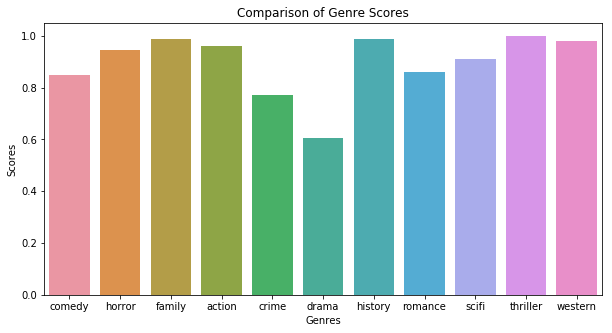

In [15]:
# Plotting average scores for classifiers when tested on datasets they were not trained on
# Labels for plot
names = ['comedy','horror','family','action','crime','drama',\
             'history','romance','scifi','thriller','western']

# Average scores for plots
genre_scores = [comedy_score,horror_score, family_score, action_score,crime_score,drama_score, 
                history_score,romance_score,scifi_score, thriller_score,western_score]


# Plotting data
fig, ax = plt.subplots()
fig.set_size_inches(10,5) #Made it longer in length to fit presentation
gs = sns.barplot(x=names, y=genre_scores, ax=ax)
gs.set_title('Comparison of Genre Scores')
gs.set_ylabel('Scores')
gs.set_xlabel('Genres')

plt.show()

All of the classifiers perform well, better than expected with the limited amount of training data fed into them. It is possible that these models overfit, but it can be seen through testing them on genre groups that were not contained in teh training set - they still perform very well. The lowest performing classifier is Drama, which is a bit unavoidable considering it's overlap with many different genres including Comedy, Romance, and Thriller. With that being said, we are still predicting above 70% on the testing sets so we can conclude that this classifier also performs well and move on to the prediction portion of our program.

In [16]:
# Getting most topical sentence from input plot paragraph
def get_summary(data_plot_sent):
    #Load parser in english
    parser = spacy.load('en')

    # Parsing the input plot data
    plot_doc = parser(data_plot_sent)

    # Dividing the text into sentences and storing them as a list of strings.
    sentences=[]
    for span in plot_doc.sents:
        # Go from the start to the end of each span, returning each token in the sentence
        # Combine each token using join()
        sent = ''.join(plot_doc[i].string for i in range(span.start, span.end)).strip()
        # Add each sentence to list of sentences
        sentences.append(sent)
    
    # Initialize vectorizer for plot summary
    vect_word = TfidfVectorizer(lowercase=False, # Don't change to lowercase
                              stop_words='english', # Load stop words in english
                              ngram_range=(1, 1),  # Look at each word individually
                              analyzer=u'word', # N-gram per word
                              min_df=1, # Use all words (appear at least once)
                                )
    
    # Fit and Transform vectorizer with sentences list
    tfidf = vect_word.fit_transform(sentences)
    
    # Calculating similarity
    similarity = tfidf * tfidf.T

    # Identifying the sentence with the highest rank.
    nx_graph = nx.from_scipy_sparse_matrix(similarity)
    ranks=nx.pagerank(nx_graph, tol=.00000001)

    ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),
                    reverse=True)

    # Return sentence that is most similar (most topical sentence)
    return ranked[0][1]

In [17]:
# Creating test data from the title inputs
def create_fav_data(fav_info):
    # Initialize vectorizer for new input data
    vect = TfidfVectorizer( 
                          stop_words=None, # Use all the data
                          ngram_range=(1, 1), #n=1, look at words individually
                          min_df=1 # All words
                          )
    # Fit and Transform vectorizer with plot of input data
    fav_plot = vect.fit_transform(fav_info.Plot)
    # Create test data using previously made function with input data
    info = create_data(fav_plot,fav_info, 'Comedy')
    
    # Return test data without the isGenre column
    return info.drop(columns=['isGenre'])

# Scraper to get movie data from IMDb Api (OMDb) from input titles 
def get_movie_info(titles):
    importlist = titles
    
    #Define crawler and processer
    class ImportSpider(scrapy.Spider):
        name = "ImportedMovie"
        start_urls=[]

        # Initiating Start URLs
        for i in range(len(importlist)):
            item = str(importlist[i])
            start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

        # Identifying the information we want from the query response and extracting it using xpath.
        def parse(self, response):
            for item in response.xpath('//movie'):
                # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
                yield {
                        'Title': item.xpath('@title').extract_first(),
                    'Year': item.xpath('@year').extract_first(),
                    'Genre': item.xpath('@genre').extract_first(),
                    'Rating': item.xpath('@imdbRating').extract_first(),
                    'Plot': item.xpath('@plot').extract_first()

                }
            
    process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'ImportedData.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False   
    })
    
    #Delete file if it already exists
    if os.path.exists('ImportedData.json'):
        os.remove('ImportedData.json')
    
    #Run crawler
    process.crawl(ImportSpider)
    process.start()
    
    #Read in data created
    info = pd.read_json('ImportedData.json')
    #Create and return the testable data for the scraped data from titles
    data = create_fav_data(info)
    return data

In [18]:
# List of Genres and their corresponding classifiers
classifiers = [("Comedy", rfc_com), ("Horror", rfc_hor),("Family", rfc_fam),("Action",rfc_act),\
              ("Crime", rfc_cri),("Drama",rfc_dra),("History",rfc_his),("Romance",rfc_rom),\
              ("Science Fiction",rfc_sf),("Thriller",rfc_thr),("Western",rfc_wes)]

# List of Genres and their corresponding list of titles
titles = [("Comedy", comedy_title), ("Horror", horror_title),("Family", family_title),("Action",action_title),\
              ("Crime", crime_title),("Drama",drama_title),("History",history_title),("Romance",romance_title),\
              ("Science Fiction",scifi_title),("Thriller",thriller_title),("Western",western_title)]

# List of Genres and their corresponding original scraped datasets
datas = [("Comedy", comedy), ("Horror", horror),("Family", family),("Action",action),\
              ("Crime", crime),("Drama",drama),("History",history),("Romance",romance),\
              ("Science Fiction",scifi),("Thriller",thriller),("Western",western)]

# Getting profile (list of genres) for the three inputs
# Input is list of classifiers, and the input movie data (test_input)
def get_profile(cfrs, test_input):
    
    #Initialize empty list and max input
    profile = []
    max_input=0
    
    # Get the highest occurance of movies in a particular genre
    for item in cfrs:
        # For each item separate genre name and classifier
        genre = item[0]
        cf = item[1]
        
        # For each genre, predict whether the movie input belongs in that genre
        prediction = cf.predict(test_input)
        
        # Sum the predictions to see how many movies fit that genre
        if prediction.sum() > max_input:
            # Update max_input 
            max_input = prediction.sum()
    
    # Use highest occurance of movies to find the most popular genres
    for item in cfrs:
        # For each item separate genre name and classifier
        genre = item[0]
        cf = item[1]
        
        # For each genre, predict whether the movie input belongs in that genre
        prediction = cf.predict(test_input)
        
        # Only add the genre to the list if it occurs the same amount of times as the max
        if prediction.sum() == max_input:
            profile.append(genre)
    
    # Return a list of all of the genres that the inputs fall into
    return profile

# Program to get recommendations
def get_recommendations(cfrs, ttl):
    
    # Initialize Movie List
    movie_list = []
    
    # Add the titles of the movies that the user inputs
    movie_list.append(input("What is the first movie you like?"))
    movie_list.append(input("What is the second movie you like?"))
    movie_list.append(input("What is the third movie you like?"))
    
    # Transform the input movie list to movie data
    actual_input = get_movie_info(movie_list)
    fav_info = actual_input
    
    # Get list of most applicable genres
    profile = get_profile(cfrs, fav_info)
    
    # Random pick from liked genres
    ind = random.randint(0,len(profile)-1)
    genre = profile[ind]
    
    # Getting title list
    for item in ttl:
        if item[0] == genre:
            ttls = item[1]
            break
    
    # Random pick in appropriate genre
    ind2 = random.randint(0,len(ttls)-1)
    pick = ttls.iloc[ind2,0]
    
    # Getting plot data from the selected movie for summarization
    for g in datas:
        if g[0] == genre:
            plot_data = g[1]
    
    # Running summary function on plot for selected movie
    plot_sum = get_summary(plot_data.iloc[ind2,:].Plot)

    return pick, plot_sum

pick, plot_summ = get_recommendations(classifiers,titles)

print("\n You should watch {}. \n You will like it because: \n {}".format(pick, plot_summ))


What is the first movie you like?When Harry met Sally
What is the second movie you like?10 Things I Hate About You
What is the third movie you like?Crazy Rich Asians

 You should watch The Shawshank Redemption. 
 You will like it because: 
 The film portrays the man's unique way of dealing with his new, torturous life; along the way he befriends a number of fellow prisoners, most notably a wise long-term inmate named Red.


Our program is a bit limited in that it can only suggest a movie from the initial title list scraped from Ranker - it would be greatly improved if it had an expansive list of all popular movies in a particular genre to train to both train the classifiers on and suggest from. But we did what we set out to do, which was to recommend a movie based on movies that the user likes. A key element of this program is that any valid movie can be input because we scrape the data from IMDB, so we do not limit ourselves on the movies that can be input.

This program does need access to the internet to scrape the data for the input movies, but other than that it is pretty self contained and could work well in a production environment. The need of running a scraper as part of the program is a bit of a limitation as the Kernel would need to be killed in a program to restart it if there is a similar task that needs to be completed. To be completely self-sufficient, this program would require the storage of between 1000-10000 rows of movie data, which is reasonable in terms of storage space.

Overall, I would say we successfully recommended a movie based on the current system storage limitations.

# Appendix:
### A. Gathering information.
Collecting popular titles by genre from Ranker.com via webscraper and collecting the movie data (plot, ranking, and year) from IMDB using their open api OMDB.

In [19]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class ComedySpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Comedy"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/crowdranked-list/100-all-time-greatest-comedy-films/',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Comedy.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(ComedySpider)
# process.start()
# print('Comedy Extracted!')

In [20]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class HorrorSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Horror"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/crowdranked-list/the-greatest-horror-films-ever-made/',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Horror.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(HorrorSpider)
# process.start()
# print('Horror Extracted!')

In [21]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class ActionSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Action"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/crowdranked-list/best-action-movies',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Action.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(ActionSpider)
# process.start()
# print('Action Extracted!')

In [22]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class CrimeSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Crime"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/all-crime-movies-or-list-of-crime-movies/all-genre-movies-lists',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Crime.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(CrimeSpider)
# process.start()
# print('Crime Extracted!')

In [23]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class DramaSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Drama"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/best-intelligent-dramas/ranker-film?ref=search',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Drama.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(DramaSpider)
# process.start()
# print('Drama Extracted!')

In [24]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class FamilySpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Family"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/best-pg-family-film-movies/reference',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Family.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(FamilySpider)
# process.start()
# print('Family Extracted!')

In [25]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class HistorySpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "History"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/best-pg-13-history-movies/reference',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'History.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(HistorySpider)
# process.start()
# print('History Extracted!')

In [26]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class RomanceSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Romance"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/romance-film-movies-and-films/reference',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Romance.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(RomanceSpider)
# process.start()
# print('Romance Extracted!')

In [27]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class SciFiSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "SciFi"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/classic-science-fiction-movies/ranker-film',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'SciFi.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(SciFiSpider)
# process.start()
# print('Sci-Fi Extracted!')

In [28]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class ThrillerSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Thriller"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/list/best-pg-thriller-movies/reference',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Thriller.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(ThrillerSpider)
# process.start()
# print('Thriller Extracted!')

In [29]:
# #Running scrapers to collect movie titles by genre
# # Importing in each cell because of the kernel restarts.
# import scrapy
# import re
# from scrapy.crawler import CrawlerProcess

# class WesternSpider(scrapy.Spider):
#     # Naming the spider is important if you are running more than one spider of
#     # this class simultaneously.
#     name = "Western"
    
#     # URL(s) to start with.
#     start_urls = [
#         'https://www.ranker.com/crowdranked-list/the-best-western-movies-ever-made',
#     ]

#     # Use XPath to parse the response we get.
#     def parse(self, response):
        
#         # Iterate over every <article> element on the page.
#         for article in response.xpath('//h2'):
            
#             # Yield a dictionary with the values we want.
#             yield {
#                 'name': article.xpath('div[@class="listItem__data"]/a/text()').extract_first()
#             }

# # Tell the script how to run the crawler by passing in settings.
# # The new settings have to do with scraping etiquette.          
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',         # Store data in JSON format.
#     'FEED_URI': 'Western.json',       # Name our storage file.
#     'LOG_ENABLED': False,          # Turn off logging for now.
#     'ROBOTSTXT_OBEY': True,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True
    
# })

# # Start the crawler with our spider.
# process.crawl(WesternSpider)
# process.start()
# print('Western Extracted!')

In [30]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class CMSpider(scrapy.Spider):
#     name = "Movie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(comedy_title)):
#         item = str(comedy_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'CMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False,
#     # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(CMSpider)
# process.start()
# print('Comedy Data Extracted!')

In [31]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class HorMSpider(scrapy.Spider):
#     name = "HorrorMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(horror_title)):
#         item = str(horror_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'HorMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False   
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(HorMSpider)
# process.start()
# print('Horror Data Extracted!')

In [32]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class ActMSpider(scrapy.Spider):
#     name = "ActionMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(action_title)):
#         item = str(action_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'ActMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False  
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(ActMSpider)
# process.start()
# print('Action Data Extracted!')

In [33]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class CriMSpider(scrapy.Spider):
#     name = "CrimeMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(crime_title)):
#         item = str(crime_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'CriMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False   
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(CriMSpider)
# process.start()
# print('Crime Data Extracted!')

In [34]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class DraMSpider(scrapy.Spider):
#     name = "DramaMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(drama_title)):
#         item = str(drama_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'DraMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False    
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(DraMSpider)
# process.start()
# print('Drama Data Extracted!')

In [35]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class FamMSpider(scrapy.Spider):
#     name = "FamilyMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(family_title)):
#         item = str(family_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'FamMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False   
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(FamMSpider)
# process.start()
# print('Family Data Extracted!')

In [36]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class HisMSpider(scrapy.Spider):
#     name = "HistoryMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(history_title)):
#         item = str(history_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'HisMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False 
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(HisMSpider)
# process.start()
# print('History Data Extracted!')

In [37]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class RomMSpider(scrapy.Spider):
#     name = "RomanceMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(romance_title)):
#         item = str(romance_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'RomMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False    
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(RomMSpider)
# process.start()
# print('Romance Data Extracted!')

In [38]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class SFMSpider(scrapy.Spider):
#     name = "SciFiMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(scifi_title)):
#         item = str(scifi_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'SFMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False   
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(SFMSpider)
# process.start()
# print('Sci-Fi Data Extracted!')

In [39]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class ThrMSpider(scrapy.Spider):
#     name = "ThrillerMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(thriller_title)):
#         item = str(thriller_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'ThrMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(ThrMSpider)
# process.start()
# print('Thriller Data Extracted!')

In [40]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class WesMSpider(scrapy.Spider):
#     name = "WesternMovie"
#     start_urls=[]
    
#     # Initiating Start URLs
#     for i in range(len(western_title)):
#         item = str(western_title.name.loc[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'WesMovies.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False, 
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(WesMSpider)
# process.start()
# print('Western Data Extracted!')

In [41]:
# # Scraping Comedy Data
# import scrapy
# from scrapy.crawler import CrawlerProcess


# class InputSpider(scrapy.Spider):
#     name = "MovieInput"
#     start_urls=[]
    
#     input_titles = ['Batman', 'Lego Movie','Avengers']
    
#     # Initiating Start URLs
#     for i in range(len(input_titles)):
#         item = str(input_titles[i])
#         start_urls.append('http://www.omdbapi.com/?apikey=236b0bfb&r=xml&plot=full&t={}'.format(item))

#     # Identifying the information we want from the query response and extracting it using xpath.
#     def parse(self, response):
#         for item in response.xpath('//movie'):
#             # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
#             yield {
#                     'Title': item.xpath('@title').extract_first(),
#                 'Year': item.xpath('@year').extract_first(),
#                 'Genre': item.xpath('@genre').extract_first(),
#                 'Rating': item.xpath('@imdbRating').extract_first(),
#                 'Plot': item.xpath('@plot').extract_first()
                
#                     }
                 
    
# process = CrawlerProcess({
#     'FEED_FORMAT': 'json',
#     'FEED_URI': 'MovieInput.json',
#     # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
#     'ROBOTSTXT_OBEY': False,
#     'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
#     'AUTOTHROTTLE_ENABLED': True,
#     'HTTPCACHE_ENABLED': True,
#     'LOG_ENABLED': False, 
# })
                                         

# # Starting the crawler with our spider.
# process.crawl(InputSpider)
# process.start()
# print('Movie Input Extracted!')